## 1- Import libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
# Right after importing seaborn (could also use 'whitegrid')
sns.set_theme(style='darkgrid', context='talk')

import warnings
warnings.filterwarnings('ignore')

from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
from numpy import sqrt
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
pd.plotting.register_matplotlib_converters()
import copy

## 2- Load data

In [2]:

df = pd.read_csv('/Users/alijanehsan/Downloads/Final_project/merge.csv', index_col =0)

In [131]:
df.head()

,date,item_code,quantity,unit_price_vat_excl,unit_cogs,unit_rrp_vat_excl,department,site,sale,country,item_name,style,name,group0,group1,category,gender,age,color,size,kids,men,unisex,women,day,month
0,2022-01-14,ZB00245086,1,107.443868,63.815891,126.367186,E-COMMER,top4running.at,107.443868,Austria,Cloudsurfer,54-99218,On Running,Footwear,Running shoes,running,men,adults,White,44,0,1,0,0,Friday,January
1,2021-12-09,ZB00245086,1,98.582325,63.816279,129.458420,E-COMMER,top4running.it,98.582325,Italy,Cloudsurfer,54-99218,On Running,Footwear,Running shoes,running,men,adults,White,44,0,1,0,0,Thursday,December
2,2021-12-08,ZB00245086,1,100.182074,63.815891,131.559296,E-COMMER,top4running.at,100.182074,Austria,Cloudsurfer,54-99218,On Running,Footwear,Running shoes,running,men,adults,White,44,0,1,0,0,Wednesday,December
3,2021-12-04,ZB00245086,1,98.350139,63.816279,129.153514,E-COMMER,top4running.it,98.350139,Italy,Cloudsurfer,54-99218,On Running,Footwear,Running shoes,running,men,adults,White,44,0,1,0,0,Saturday,December
4,2021-11-14,ZB00245086,1,99.296899,63.815891,130.396884,E-COMMER,top4running.at,99.296899,Austria,Cloudsurfer,54-99218,On Running,Footwear,Running shoes,running,men,adults,White,44,0,1,0,0,Sunday,November


## 3- Get monthly data
For monthly forcasting we need to summarize data for each month

In [12]:
def monthly_data(df, time_period='month', sale='net'):
    time_periods = {
        'day': 'D',
        'week': 'W',
        'month': 'M'}
    
    revenue_cat = {
        'net':'Revenue'}
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df = df[revenue_cat[sale]].resample(time_periods[time_period]).sum()
    df = pd.DataFrame(df).reset_index()
    return df

In [23]:
df_m = monthly_data(df)
#df_m.columns=['ds', 'y']
df_m.ds=pd.to_datetime(df_m['date'])
df_m.sort_values('date')
df_m.head()

,date,Revenue
0,2019-06-30,458077.500230
1,2019-07-31,661605.989647
2,2019-08-31,910477.102034
3,2019-09-30,860163.234682
4,2019-10-31,703325.788071


## 4-Check whether the data is stationary or not

In [24]:
plot_data = [
    go.Scatter(
        x=df_m['date'],
        y=df_m['Revenue'],
    )
]
plot_layout = go.Layout(
        title='Montly Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Check with Dicky Fuller test

The plot  showS that  the data is not stationary.  So we need to make our data stationary

In [25]:
df_diff = df_m.copy()
#add previous sales to the next row
df_diff['prev_sales'] = df_diff['Revenue'].shift(1)
#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['Revenue'] - df_diff['prev_sales'])
df_diff.head(10)

,date,Revenue,prev_sales,diff
1,2019-07-31,6.616060e+05,4.580775e+05,203528.489416
2,2019-08-31,9.104771e+05,6.616060e+05,248871.112387
3,2019-09-30,8.601632e+05,9.104771e+05,-50313.867352
4,2019-10-31,7.033258e+05,8.601632e+05,-156837.446611
5,2019-11-30,1.312387e+06,7.033258e+05,609061.371501
6,2019-12-31,1.382256e+06,1.312387e+06,69868.536177
7,2020-01-31,1.017721e+06,1.382256e+06,-364534.435134
8,2020-02-29,8.523137e+05,1.017721e+06,-165407.590774
9,2020-03-31,8.334149e+05,8.523137e+05,-18898.795824
10,2020-04-30,9.226340e+05,8.334149e+05,89219.143904


In [27]:
plot_data = [
    go.Scatter(
        x=df_diff['date'],
        y=df_diff['diff'],
    )
]
plot_layout = go.Layout(
        title='Montly Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [28]:
# Check agian and see the Dicky Fuller test result
from statsmodels.tsa.stattools import adfuller
print("Observations of Dickey-fuller test")
dftest = adfuller(df_diff['diff'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                 -4.645564
p-value                         0.000106
#lags used                      2.000000
number of observations used    28.000000
critical value (1%)            -3.688926
critical value (5%)            -2.971989
critical value (10%)           -2.625296
dtype: float64


Perfect, Now we can see that our data is stationary

## 5-Make the data ready for fb prophet modeling

In [29]:

# Rename the date and sales columns based the fb prophet requirement
df_diff = df_diff.rename(columns={'date':'ds', 'diff':'y'})
df_diff

,ds,Revenue,prev_sales,y
1,2019-07-31,6.616060e+05,4.580775e+05,2.035285e+05
2,2019-08-31,9.104771e+05,6.616060e+05,2.488711e+05
3,2019-09-30,8.601632e+05,9.104771e+05,-5.031387e+04
4,2019-10-31,7.033258e+05,8.601632e+05,-1.568374e+05
5,2019-11-30,1.312387e+06,7.033258e+05,6.090614e+05
6,2019-12-31,1.382256e+06,1.312387e+06,6.986854e+04
7,2020-01-31,1.017721e+06,1.382256e+06,-3.645344e+05
8,2020-02-29,8.523137e+05,1.017721e+06,-1.654076e+05
9,2020-03-31,8.334149e+05,8.523137e+05,-1.889880e+04
10,2020-04-30,9.226340e+05,8.334149e+05,8.921914e+04


In [30]:
df_fb = df_diff[['ds','y']]
df_fb

,ds,y
1,2019-07-31,2.035285e+05
2,2019-08-31,2.488711e+05
3,2019-09-30,-5.031387e+04
4,2019-10-31,-1.568374e+05
5,2019-11-30,6.090614e+05
6,2019-12-31,6.986854e+04
7,2020-01-31,-3.645344e+05
8,2020-02-29,-1.654076e+05
9,2020-03-31,-1.889880e+04
10,2020-04-30,8.921914e+04


## 6-Split our data into test and training set

In [31]:
# Divide our data into test and train set
train=df_fb[:26]
test=df_fb[26:]

This code plot both the test and train set in case that we want. I skip it

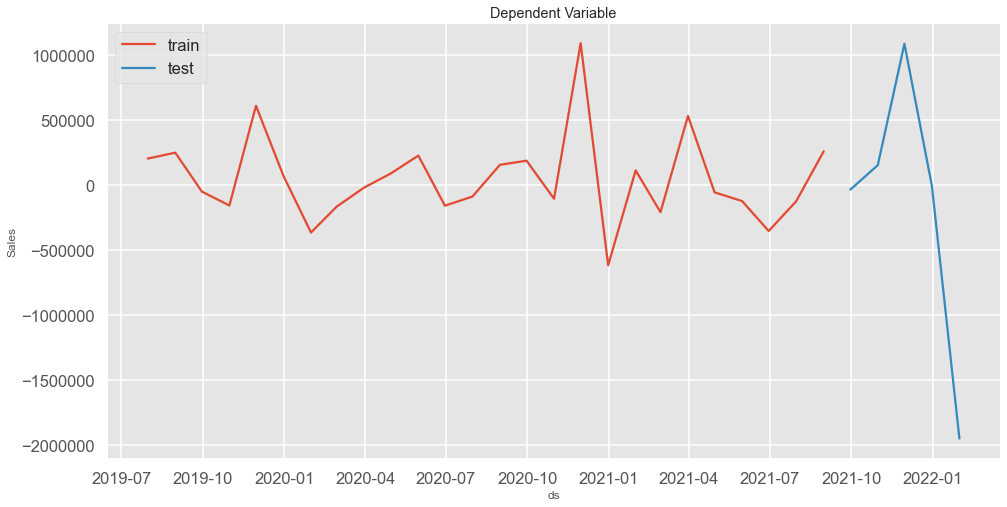

In [32]:
# Lets plot the both data
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x='ds', y='y', label='train', data=train, ax=ax)
sns.lineplot(x='ds', y='y', label='test', data=test, ax=ax)
plt.ticklabel_format(style='plain', axis='y')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='Sales');
plt.ticklabel_format(style='plain', axis='y')

## 7- Modeling

In [33]:
# Instantiate and train the model
m = Prophet(weekly_seasonality=True,yearly_seasonality=True)
m.add_seasonality(name='monthly', period=24, fourier_order=1)
#m.add_country_holidays(country_name='UK')
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


In [34]:

#future = m.make_future_dataframe(periods=7, #include_history=True)
future = m.make_future_dataframe(periods=7, freq = 'M')
forecast = m.predict(future)
#print(m.make_future_dataframe(periods=5, freq='M'))

In [35]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-07-31,226085.343036,2.035285e+05,2.035285e+05,226085.343036,226085.343036,-2.255685e+04,-2.255685e+04,-2.255685e+04,-60416.594465,-60416.594465,-60416.594465,9882.904643,9882.904643,9882.904643,2.797684e+04,2.797684e+04,2.797684e+04,0.0,0.0,0.0,2.035285e+05
1,2019-08-31,219275.237223,2.488711e+05,2.488711e+05,219275.237223,219275.237223,2.959588e+04,2.959588e+04,2.959588e+04,-290784.367174,-290784.367174,-290784.367174,-298767.423154,-298767.423154,-298767.423154,6.191477e+05,6.191477e+05,6.191477e+05,0.0,0.0,0.0,2.488711e+05
2,2019-09-30,212684.202629,-5.031387e+04,-5.031387e+04,212684.202629,212684.202629,-2.629981e+05,-2.629981e+05,-2.629981e+05,140463.297507,140463.297507,140463.297507,210685.590328,210685.590328,210685.590328,-6.141470e+05,-6.141470e+05,-6.141470e+05,0.0,0.0,0.0,-5.031387e+04
3,2019-10-31,205874.385406,-1.568374e+05,-1.568374e+05,205874.385406,205874.385406,-3.627118e+05,-3.627118e+05,-3.627118e+05,244521.553602,244521.553602,244521.553602,11702.614499,11702.614499,11702.614499,-6.189360e+05,-6.189360e+05,-6.189360e+05,0.0,0.0,0.0,-1.568374e+05
4,2019-11-30,199283.515301,6.090614e+05,6.090614e+05,199283.515301,199283.515301,4.097779e+05,4.097779e+05,4.097779e+05,-210937.658950,-210937.658950,-210937.658950,-298767.423154,-298767.423154,-298767.423154,9.194829e+05,9.194829e+05,9.194829e+05,0.0,0.0,0.0,6.090614e+05
5,2019-12-31,192473.521964,6.986854e+04,6.986854e+04,192473.521964,192473.521964,-1.226050e+05,-1.226050e+05,-1.226050e+05,-181595.000243,-181595.000243,-181595.000243,-116918.631076,-116918.631076,-116918.631076,1.759086e+05,1.759086e+05,1.759086e+05,0.0,0.0,0.0,6.986854e+04
6,2020-01-31,185663.700132,-3.645344e+05,-3.645344e+05,185663.700132,185663.700132,-5.501981e+05,-5.501981e+05,-5.501981e+05,304938.148066,304938.148066,304938.148066,-86009.474307,-86009.474307,-86009.474307,-7.691268e+05,-7.691268e+05,-7.691268e+05,0.0,0.0,0.0,-3.645344e+05
7,2020-02-29,179293.210965,-1.654076e+05,-1.654076e+05,179293.210965,179293.210965,-3.447008e+05,-3.447008e+05,-3.447008e+05,181595.000243,181595.000243,181595.000243,-298767.423155,-298767.423155,-298767.423155,-2.275284e+05,-2.275284e+05,-2.275284e+05,0.0,0.0,0.0,-1.654076e+05
8,2020-03-31,172485.569623,-1.889880e+04,-1.889880e+04,172485.569623,172485.569623,-1.913844e+05,-1.913844e+05,-1.913844e+05,-304938.148066,-304938.148066,-304938.148066,-116918.631076,-116918.631076,-116918.631076,2.304724e+05,2.304724e+05,2.304724e+05,0.0,0.0,0.0,-1.889880e+04
9,2020-04-30,165903.430968,8.921914e+04,8.921914e+04,165903.430968,165903.430968,-7.668429e+04,-7.668429e+04,-7.668429e+04,-106293.047717,-106293.047717,-106293.047717,11702.614500,11702.614500,11702.614500,1.790615e+04,1.790615e+04,1.790615e+04,0.0,0.0,0.0,8.921914e+04


Plot the forecast

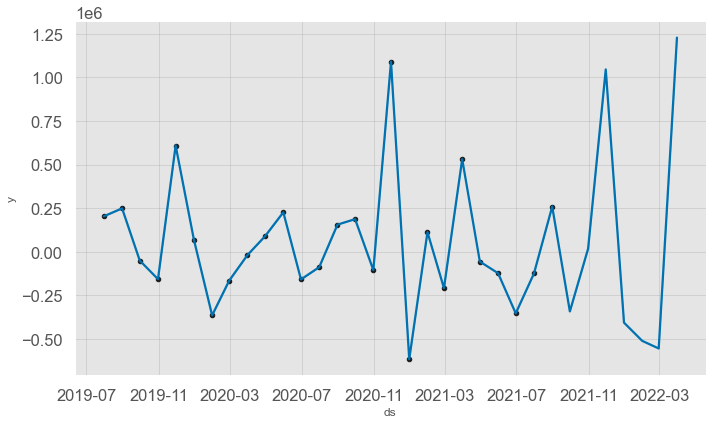

In [36]:
fig1 = m.plot(forecast)

 Plot the components 

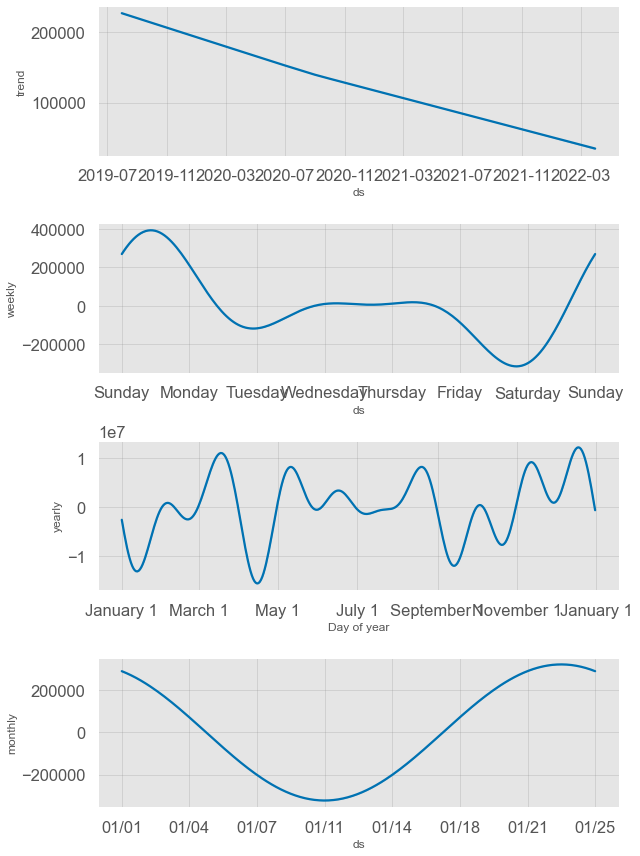

In [37]:
fig2 = m.plot_components(forecast)

<function matplotlib.pyplot.show(close=None, block=None)>

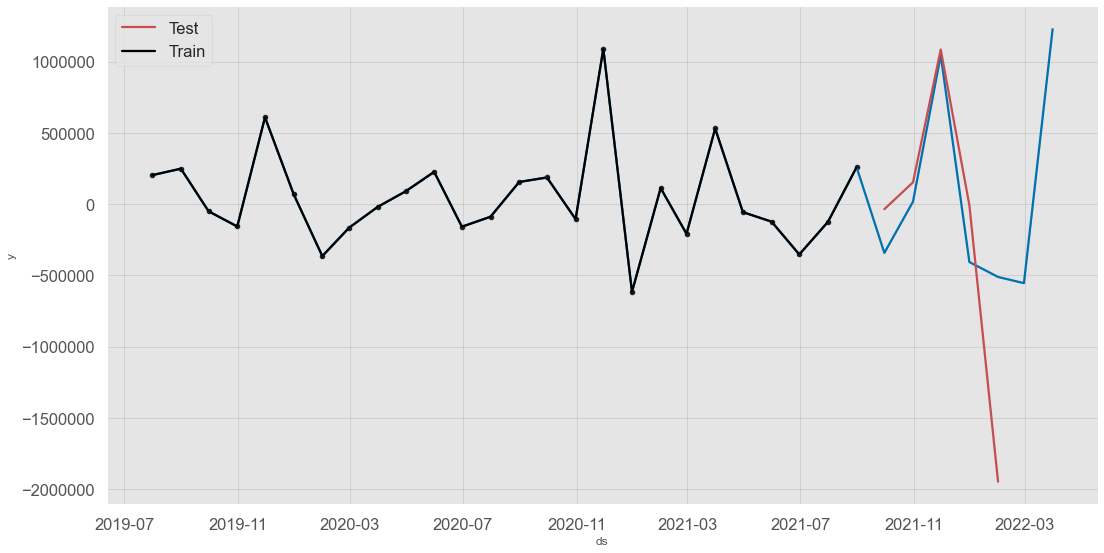

In [39]:
# Let's coampare the prediction with actual

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


fig=m.plot(forecast, ax=ax)
ax.plot(test.ds, test.y, color='r', label='Test')
ax.plot(train.ds, train.y, color='black', label='Train')
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.show


## 8-Evaluate our model performance

In [40]:
df_merge = pd.merge(test, forecast[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge = df_merge[['ds','yhat_lower','yhat_upper','yhat','y']]
df_merge.head()

,ds,yhat_lower,yhat_upper,yhat,y
0,2021-09-30,-3.421190e+05,-3.420579e+05,-3.420872e+05,-3.511098e+04
1,2021-10-31,1.763611e+04,1.788640e+04,1.776616e+04,1.530401e+05
2,2021-11-30,1.045237e+06,1.045724e+06,1.045490e+06,1.085221e+06
3,2021-12-31,-4.066440e+05,-4.058393e+05,-4.062256e+05,-8.143882e+03
4,2022-01-31,-5.114125e+05,-5.102439e+05,-5.108013e+05,-1.947112e+06


In [41]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

y_true = df_merge['y'].values
y_pred = df_merge['yhat'].values
#mae_01 = mean_absolute_error(y_true, y_pred)
mape_01 = mean_absolute_percentage_error(y_true, y_pred)

print( 'MAPE:',mape_01)

## 9- Cross Validation

In [42]:
from fbprophet.diagnostics import cross_validation
df_cv=cross_validation(model=m, horizon='30 days', period='30 days')
mape=mean_absolute_percentage_error(df_cv.y, df_cv.yhat)
print('MAPE: ', mape)

INFO:fbprophet:Making 13 forecasts with cutoffs between 2020-08-06 00:00:00 and 2021-08-01 00:00:00
100%|██████████| 13/13 [03:50<00:00, 17.72s/it]

MAPE:  12.500487770623307


# Performance metrics

In [43]:
from fbprophet.diagnostics import performance_metrics
per_df = performance_metrics(df_cv)
per_df.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,25 days,5.590309e+11,7.476837e+05,6.112595e+05,3.362947,3.362947,0.0
1,26 days,5.990607e+12,2.447572e+06,2.095868e+06,14.911136,11.853074,0.0
2,27 days,1.376248e+13,3.709782e+06,2.972878e+06,7.280406,7.332170,0.0
3,28 days,1.474456e+13,3.839864e+06,2.479730e+06,21.004034,2.933247,0.0
4,29 days,7.978799e+12,2.824677e+06,2.824677e+06,22.725884,22.725884,0.0


Compare actual and forecasted values after crossvalidation

Text(0.5, 1.0, 'Forecast Vs Actual')

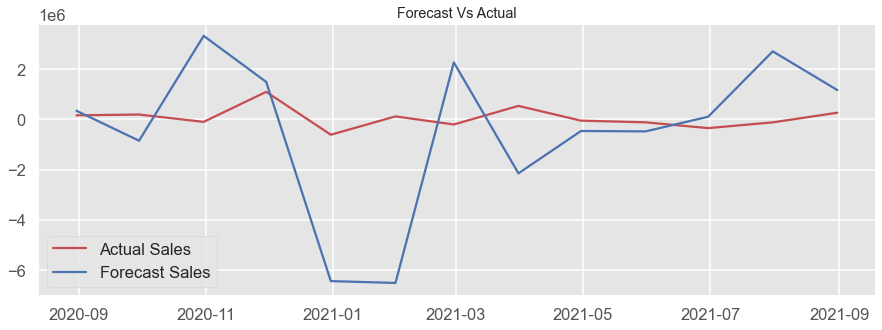

In [45]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(df_cv['ds'], df_cv['y'], color='r', label='Actual Sales')
ax.plot(df_cv['ds'], df_cv['yhat'], color='b', label='Forecast Sales')
plt.legend()

plt.title('Forecast Vs Actual')

## 11- Tunning parameters

In [46]:
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],   
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the MAE for each params here
mapes = [] # Store the MAPE for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])
    mapes.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
tuning_results['mape'] = mapes

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:Making 25 forecasts with cutoffs between 2020-08-06 00:00:00 and 2021-08-01 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f83d0019730>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:Making 25 forecasts with cutoffs between 2020-08-06 00:00:00 and 2021-08-01 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f83cd15cb80>
INFO

In [47]:
tuning_results.sort_values(['mae','mape'])



,changepoint_prior_scale,seasonality_prior_scale,mae,mape
2,0.001,1.00,2.703538e+05,1.480684
14,0.500,1.00,3.338681e+05,2.030367
5,0.010,0.10,3.352700e+05,1.655759
9,0.100,0.10,3.357240e+05,1.661804
1,0.001,0.10,3.368584e+05,1.681700
13,0.500,0.10,3.484058e+05,1.836487
0,0.001,0.01,3.503348e+05,1.322816
8,0.100,0.01,3.524106e+05,1.291775
4,0.010,0.01,3.529972e+05,1.292610
12,0.500,0.01,3.531574e+05,1.294480


We can see that MAE and MAPE for different values of changepoint_prior_scale and seasonality_prior_scale hyperparameters.

## 12-  Find the best  parameters and compare the results

In [48]:
best_params = all_params[np.argmin(mapes)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


In [49]:
# Train the model with best parameters
m_01 = Prophet(weekly_seasonality=True,yearly_seasonality=True,
changepoint_prior_scale = best_params['changepoint_prior_scale'],
seasonality_prior_scale = best_params['seasonality_prior_scale'] )
m_01.add_seasonality(name='monthly', period=24, fourier_order=1)
#m.add_country_holidays(country_name='UK')
model = m_01.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


In [50]:
# Predict with tunned parameters
future_01 = model.make_future_dataframe(periods=7, freq = 'M')
forecast_01 = model.predict(future_01)

## Check the model improvement after parameter tunning

In [51]:
df_merge_1 = pd.merge(test, forecast_01[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge_1 = df_merge_1[['ds','yhat_lower','yhat_upper','yhat','y']]
df_merge_1.head()

,ds,yhat_lower,yhat_upper,yhat,y
0,2021-09-30,-434688.450230,385849.006634,-9671.177694,-3.511098e+04
1,2021-10-31,-406586.275003,453064.871184,-12764.878165,1.530401e+05
2,2021-11-30,-389153.699188,430091.013711,7689.647714,1.085221e+06
3,2021-12-31,-430067.709082,388142.508096,-29191.721506,-8.143882e+03
4,2022-01-31,-423579.297228,412267.376213,-19679.559128,-1.947112e+06


## Model perfromance before tuning parameters

In [52]:
y_true = df_merge['y'].values
y_pred = df_merge['yhat'].values
#mae_01 = mean_absolute_error(y_true, y_pred)
mape_01 = mean_absolute_percentage_error(y_true, y_pred)

print('mape before tuning parameters:',mape_01)

mape before tuning parameters: 11.856456839493248


## Model performance after tuning parameters

In [54]:
y_true_01 = df_merge_1['y'].values
y_pred_01= df_merge_1['yhat'].values
#mae_02 = mean_absolute_error(y_true_01, y_pred_01)
mape_02 = mean_absolute_percentage_error(y_true_01, y_pred_01)

print('mape after tuning prarameters:',mape_02)

mape after tuning prarameters: 1.275053431587634


 We can see that after fine-parameter tuning mape decreased from 11.856456839493248 to 1.275053431587634 which is a good sign of improvement